In [45]:
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import pickle
import spacy
import json
import io,re
import numpy as np

In [19]:
##Saving the class label to index
INDEX_TO_LABEL_FILE_PATH = "../metadata/index_to_label.json"

##Train data path
DATA_PATH = "../data/reviews_prepared_sample.txt"

##Path to save the model
MODEL_PATH = "../model/classifier.p"

<h1> Approach: </h1>
<h5>Build an SVM based multi-class classifier<br>The dataset used is a crawl of playstore reviews of an APP named "CLUE"</h5>
<h5>All the ratings 4,5 are bucketed to POSITIVE</h5>
<h5>All the ratings 3 are bucketed to NEUTRAL</h5>
<h5>All the ratings 1,2 are bucketed to NEGATIVE</h5>

<h5>Apply basic preprocessing like cleaning up special characters, convert every word to lowercase etc</h5>
<h5>(The data is build on sample of 2000 reviews)</h5>

<h2>Note: Text classification is a sequence classification problem and the best models for this are the model which can make use of the sequential information. So models like RNN, Bidirectional LSTMs are expected to work better than SVM. SVMs are good place to start because its much easier to train and produce fast inferences </h2>







<h1> Data distribution:</h1>
POSITIVE_SAMPLES:1798 <br>
NEGATIVE_SAMPLES:143 <br>
NEUTRAL_SAMPLES:58 <br>
So its heavily biased, towards Positive, however the the idea is just to show case the model training<br>
F1 is used as the evaluation metric <br>


![title](../artifacts/histogram.png)

In [20]:

print ("Loading spacy model")
spacy_model = spacy.load("en_core_web_md")
print ("Done loading spacy model")


Loading spacy model
Done loading spacy model


In [76]:
#We use Spacy to do the heavy lifting of converting strings to vectors
#One exmple could be 
spacy_model("How are you").vector
#spay basically averages out teh vectors of each word to produce a 300 dimension representation of the sentence

300

In [72]:
##Function to save index_to_label mappings to be used for inference
def save_index_to_label_mapping(label_indexes,le):
    """Save index_to_label mappings to be used for inference.
            @param label_indexes  indexes of the classes (n labels for n-class classification)
            @param le --> is the labelencoder used for preparing data

            returns () --> Just saves the mapping"""
    index_to_label_dict = {}
    label_indexes_list = list(set(label_indexes))
    labels_list = le.inverse_transform(label_indexes_list)
    for i in range(len(labels_list)):
        index_to_label_dict[str(label_indexes_list[i])] = labels_list[i]

    with open(INDEX_TO_LABEL_FILE_PATH, 'w') as outfile:
        json.dump(index_to_label_dict, outfile)

In [71]:
##One of the preprocessing step
def lemmatize(text):
    """Lemmatizes the input sentence
            @param text : The input sentence which is to be lemmatized

            returns lemmatized sentence"""
    
    sent = []
    doc = spacy_model(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)

In [ ]:

def clean_sentence(sent):
     """Remove all special characters except space,?
            @param sent : The input sentence which is to be cleaned

            returns cleaned sentence : lowercase, special symbols removed, adjascent spaces removed """
    
    sent = sent.lower() 
    sent = sent.replace('\n', ' ')
    sent = re.sub('[^A-Za-z0-9 ]+', ' ', sent)
    sent = re.sub(' +', ' ', sent)      #Removing adjascent spaces
    return sent.strip(" ")




In [69]:
def get_data():
    """Load X, Y from the data file 
            Applies a basic preprocessing pipeline which cleans, lemmatizes the document  : 
            returns X,Y : Both are lists """
    
    print("Loading data...")
    with io.open(DATA_PATH,"r",encoding="utf-8") as f:
        x_data = []
        y_data = []
        for line in f:
            if(line.__contains__(",,,") and len(line.split(",,,")) == 2):
                line_splitted = line.split(",,,")
                x = line_splitted[0].strip()
                y = line_splitted[1].strip()

                x_cleaned = clean_sentence(x)

                x_lemmatized = lemmatize(x_cleaned)
                x_data.append(np.array(spacy_model(x_lemmatized).vector))
                y_data.append(y)
    return x_data,y_data

Loading data...
POSITIVE_SAMPLES:1798
NEGATIVE_SAMPLES:143
NEUTRAL_SAMPLES:58


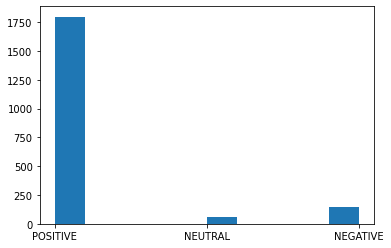

In [80]:
_,Y = get_data()
from matplotlib import pyplot as plt

print("POSITIVE_SAMPLES:" + str(Y.count("POSITIVE")))
print("NEGATIVE_SAMPLES:" + str(Y.count("NEGATIVE")))
print("NEUTRAL_SAMPLES:" + str(Y.count("NEUTRAL")))
plt.hist(Y)
plt.savefig("../artifacts/histogram.png")



In [56]:
def get_svm_config():
    """Basic config for grid search 
            returns dict which contains kernel, C which needs to be tried """
    config = {
        "kernel": "linear",
        "C": [1,2,5,10,20,100]
    }
    return config


In [82]:
def train():
    """Core training logic - Saves the trained classifier
            returns Nothing """
    X, labels = get_data()
    X, labels = shuffle(X,labels)
    le = LabelEncoder()
    y = le.fit_transform(labels)


    save_index_to_label_mapping(y,le)

    sklearn_config = get_svm_config()
    C = sklearn_config.get("C")
    kernel = sklearn_config.get("kernel")

    params_grid = [{"C": C, "kernel": [str(kernel)]}]

    clf = GridSearchCV(SVC(probability=True, class_weight='balanced',decision_function_shape='ovr'),
                            param_grid=params_grid,
                            cv=5, scoring='f1_weighted', verbose=1)

    clf.fit(X, y)
    print("best params : {} , best F1: {}".format(clf.best_params_,clf.best_score_))
    f = open(MODEL_PATH, 'wb')
    pickle.dump(clf, f)
    f.close()

In [83]:
train()

Loading data...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
best params : {'C': 2, 'kernel': 'linear'} , best F1: 0.856120724635808
